## Demonstration of how `sfrmaker` handles streambed elevations

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import flopy
fm = flopy.modflow
import matplotlib.pyplot as plt
from sfrmaker import Lines, StructuredGrid
from sfrmaker.utils import assign_layers


### Run the first part of the Tyler Forks example problem to get an `SFRData` instance

In [2]:
# DEM for sampling streambed top elevations
dem = '../tylerforks/dem_26715.tif'

# output folder
outdir = 'temp/'
if not os.path.isdir(outdir):
    os.mkdir(outdir)

# make an instance of the sfrmaker.Lines class from NHDPlus data
# use a shapefile of the model grid to filter what is read in
# (only flowlines within the bounding box of the grid are read)
lns = Lines.from_nhdplus_v2(NHDPlus_paths='../tylerforks/NHDPlus/',
                            bbox_filter='../tylerforks/grid.shp')

# load the model using flopy
m = fm.Modflow.load('tf.nam', model_ws='../tylerforks/tylerforks')

# Make a flopy StructuredGrid instance
# delr and delc have to specified in meters (consistent with projected CRS)
# the model has length units of feet
mg = flopy.discretization.StructuredGrid(delr=m.dis.delr.array * .3048,  # cell spacing along a row
                                         delc=m.dis.delc.array * .3048,  # cell spacing along a column
                                         xoff=682688, yoff=5139052,  # lower left corner of model grid
                                         angrot=0,  # grid is unrotated
                                         # projected coordinate system of model (UTM NAD27 zone 15 North)
                                         crs=26715
                                         )

# from the lines and StructuredGrid instances, make a sfrmaker.SFRData instance
# (lines are intersected with the model grid and converted to reaches, etc.)
# unfortunately there are 3 different ways to specify model length units
# SFRmaker will set the units in this order of priority:
# 1) as argued with model_length_units= (below)
# 2) units attached to sfrmaker.StructuredGrid instance
# 3) units attached to DIS package of flopy model
# if the grid or model dis package have valid units, any conversions should "just work"
# in any case, specifying units in the to_sfr call guarantees that the correct units will be used
sfr = lns.to_sfr(grid=mg, model=m, model_length_units='feet')


loading NHDPlus v2 hydrography data...
for basins:
../tylerforks/NHDPlus/

reading ../tylerforks/NHDPlus/NHDPlusAttributes/PlusFlow.dbf...
--> building dataframe... (may take a while for large shapefiles)

load finished in 0.07s

Getting routing information from NHDPlus Plusflow table...
finished in 0.03s


SFRmaker version 0.11.2.post14.dev0+gca5c4bf

Creating sfr dataset...

Creating grid class instance from flopy Grid instance...


grid class created in 0.39s

Model grid information
structured grid
nnodes: 17,760
nlay: 1
nrow: 111
ncol: 160
model length units: undefined
crs: EPSG:26715
bounds: 682688.00, 5139052.00, 694880.00, 5147510.20
active area defined by: all cells

MODFLOW 5 layer(s) 111 row(s) 160 column(s) 1 stress period(s)

reprojecting hydrography from
EPSG:4269
to
EPSG:26715


Culling hydrography to active area...
starting lines: 43
remaining lines: 42
finished in 0.00s


Intersecting 42 flowlines with 17,760 grid cells...

Building spatial index...


finished in 0.90s

Intersecting 42 features...
42
finished in 0.13s

Setting up reach data... (may take a few minutes for large grids)


finished in 0.45s

Computing widths...

Dropping 48 reaches with length < 12.50 feet...

Repairing routing connections...
enforcing best segment numbering...

Setting up segment data...
Model grid information
structured grid
nnodes: 17,760
nlay: 1
nrow: 111
ncol: 160
model length units: undefined
crs: EPSG:26715
bounds: 682688.00, 5139052.00, 694880.00, 5147510.20
active area defined by: all cells


Time to create sfr dataset: 2.02s



### Sample elevations from the DEM
* the **buffers** method draws a buffer around each LineString representing a reach (default=100m), and then gets the minimum DEM elevation within that buffer, using the **`rasterstats`** package
* alternatively, the **`cell polygons`** method would do the same thing using the model cell polygons instead to represent the reaches
* get results with and without smoothing. 

#### pseudo code for the smoothing algoritm:  


```
Starting at the outlets to the stream network, list the reaches at each level (reaches that route to an outlet, reaches that route to reaches that route to an outlet, etc...)
For each level:
    For each stream reach within the level:
        Get the elevations of all upstream reaches (that route to that reach)
            Set the elevation as the minimum of the elevation sampled at the current reach and the elevations sampled at all upstream reaches.
```
        

In [3]:
raw_sampled_elevs = sfr.sample_reach_elevations(dem, method='buffers', smooth=False)
smooth_sampled_elevs = sfr.sample_reach_elevations(dem, method='buffers', smooth=True)

running rasterstats.zonal_stats on buffered LineStrings...


finished in 8.51s

running rasterstats.zonal_stats on buffered LineStrings...


finished in 8.40s


Smoothing elevations...
finished in 0.09s


### Make comparison plots of the elevations in each segment
* model_top: elevations sampled from the DEM at the cell centers
* nhdplus_elevations: reach elevations linearly interpolated from original COMID end elevations in NHDPlus
* raw_sampled_elevs: minimum DEM elevations within each buffered LineString
* smooth_sampled_elevs: minimum DEM elevations within each buffered LineString with smoothing applied

#### Note:
One of the segments has NHDPlus elevations that are much higher than the model top or DEM. This is due to the segment originating outside of the model domain, which means the COMID start elevation from NHDPlus is invalid.

In [4]:
dfs = []
segments = sfr.reach_data.groupby('iseg')
for iseg, srd in segments:
    df = srd.copy()
    df['dist'] = srd.rchlen.cumsum()
    df['NHDPlus elevations'] = df.strtop
    dfs.append(df[['i', 'j', 'rno', 'iseg', 'ireach', 'dist', 'NHDPlus elevations']])
df = pd.concat(dfs)
df['model top'] = sfr.model.dis.top.array[df.i, df.j]
df['raw sampled elevations'] = [raw_sampled_elevs[rno]
                              for rno in df['rno'].values]
df['smoothed sampled elevations'] = [smooth_sampled_elevs[rno]
                              for rno in df['rno'].values]
df['smoothed sampled elevations'] /= .3048 # convert from meters to feet
df['raw sampled elevations'] /= .3048

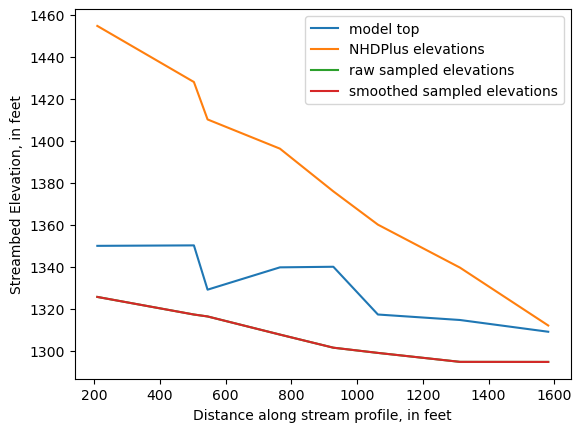

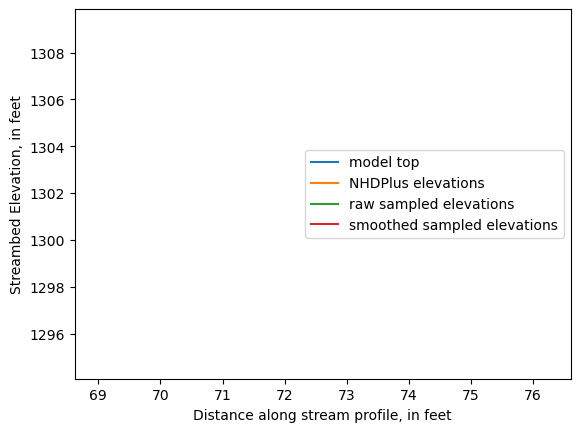

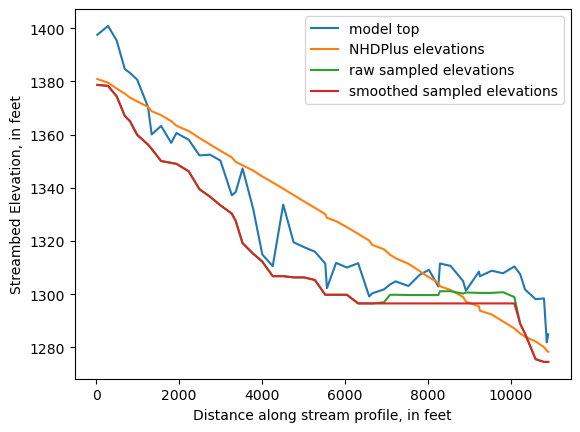

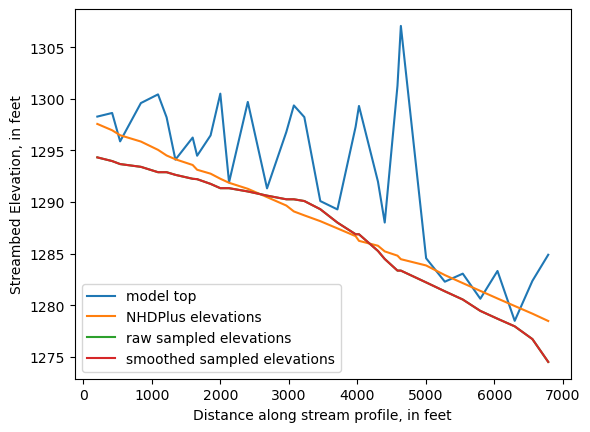

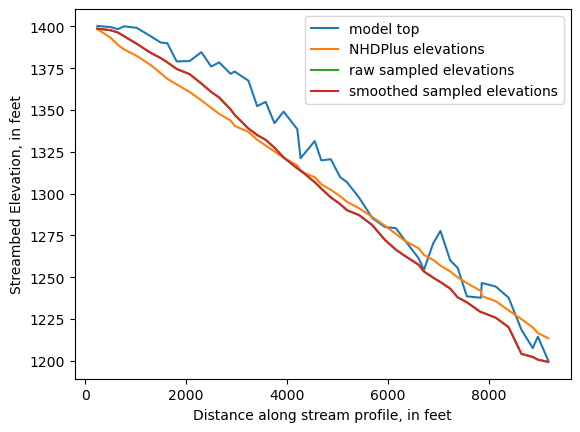

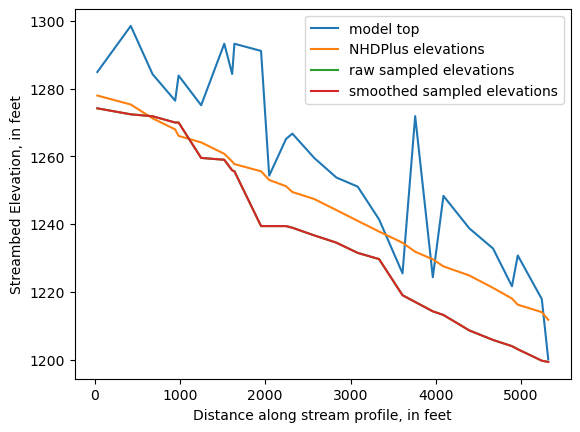

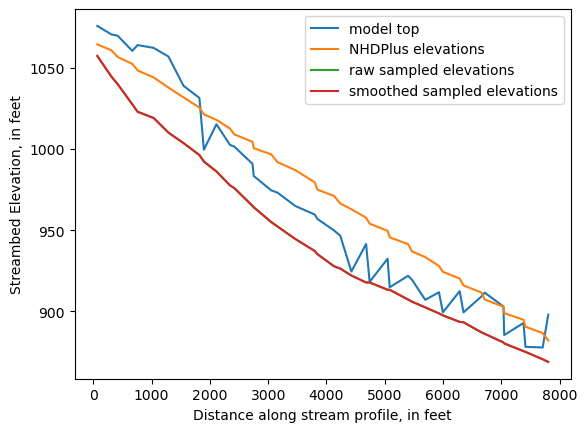

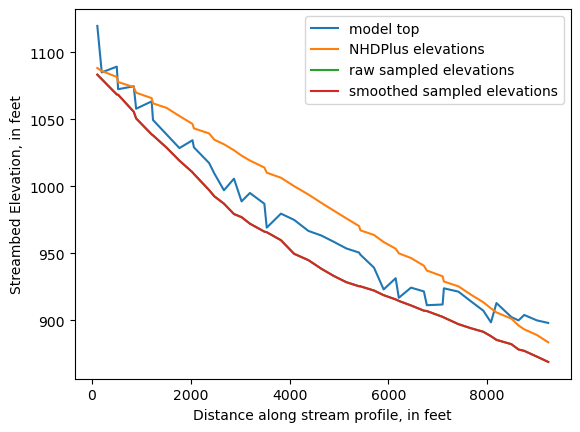

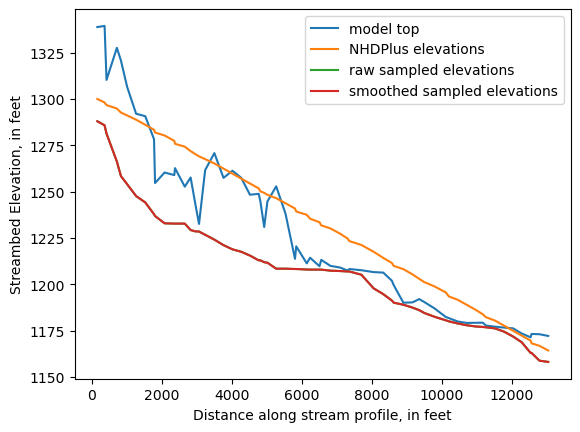

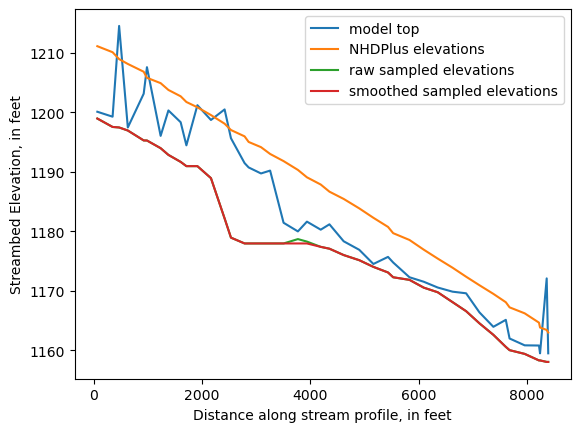

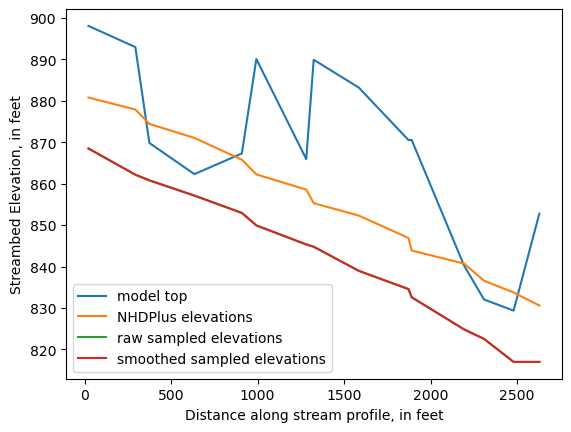

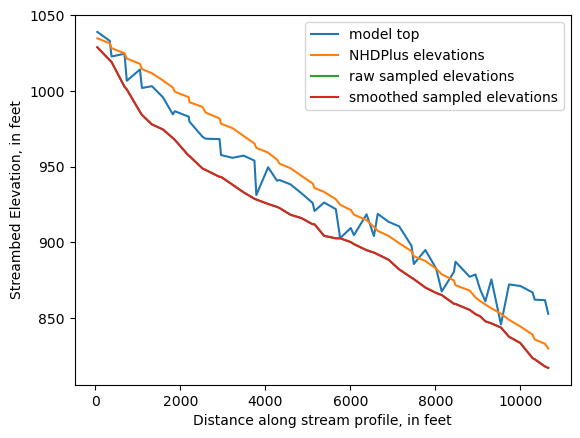

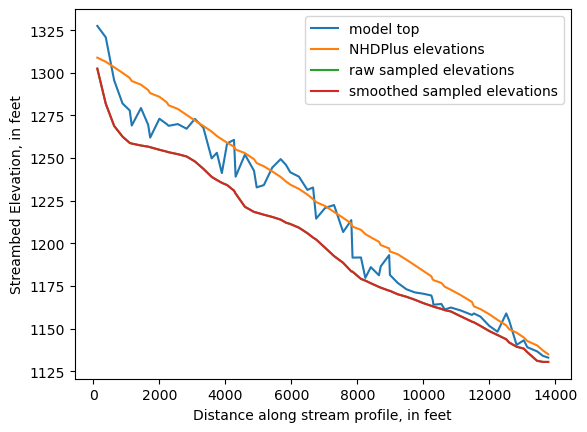

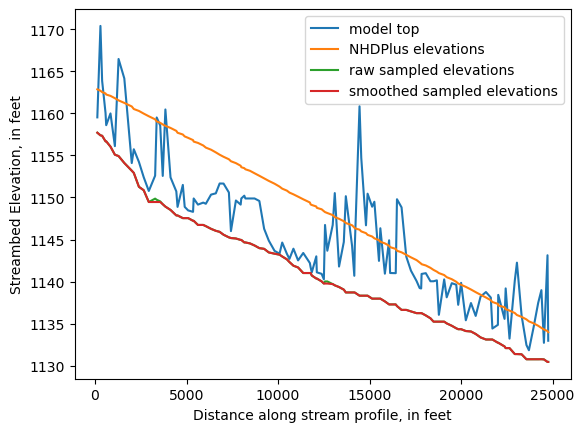

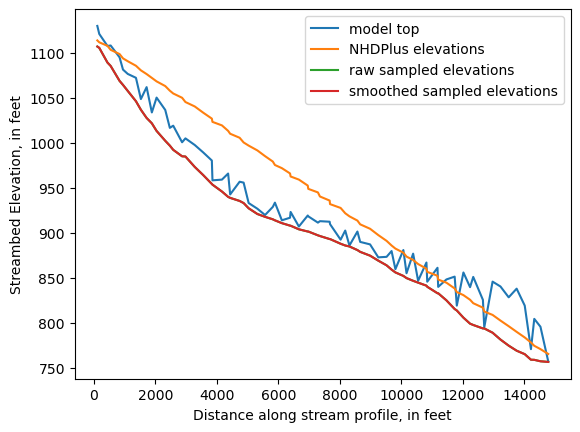

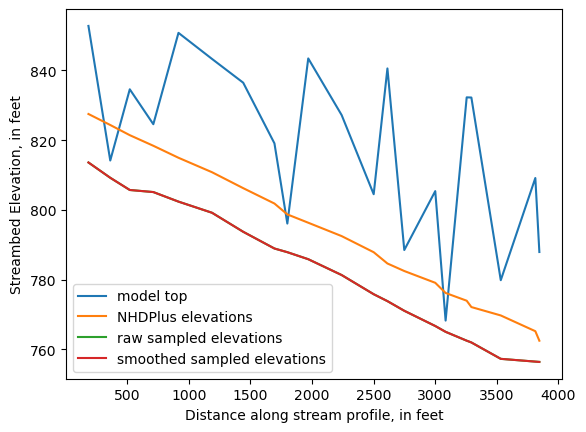

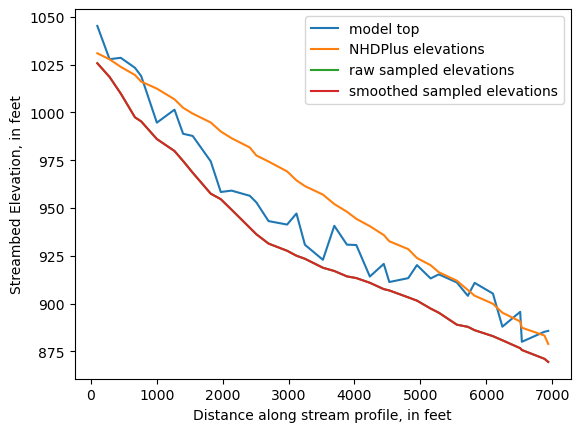

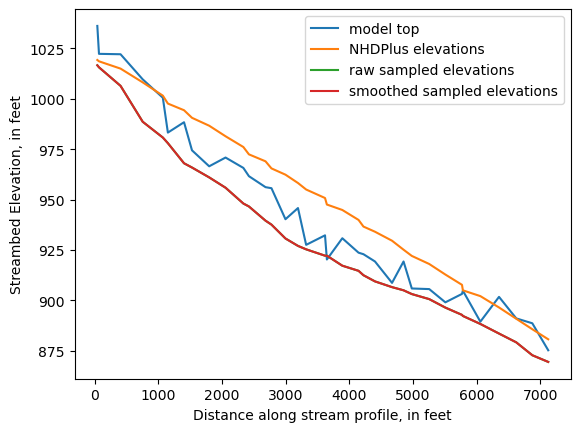

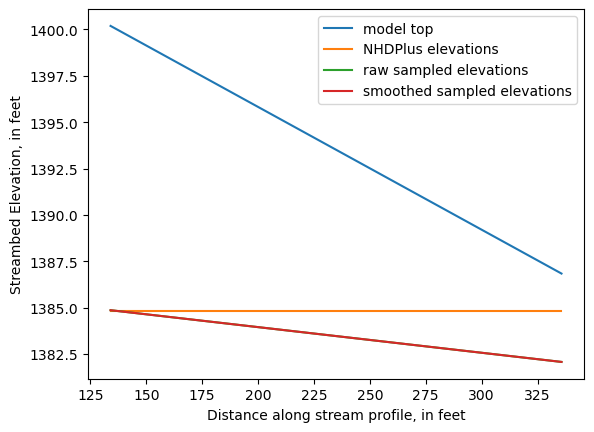

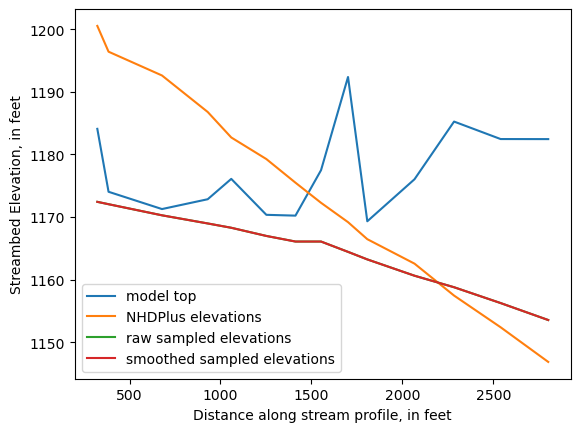

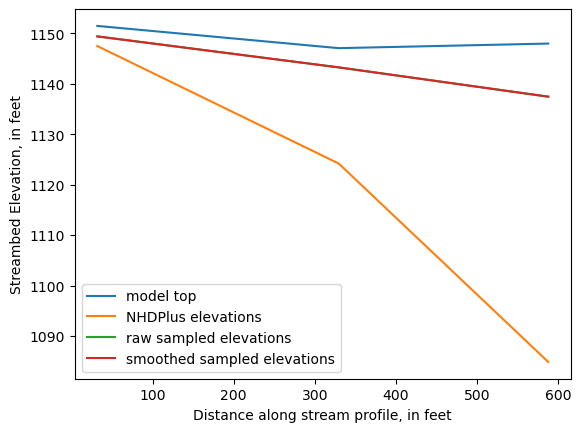

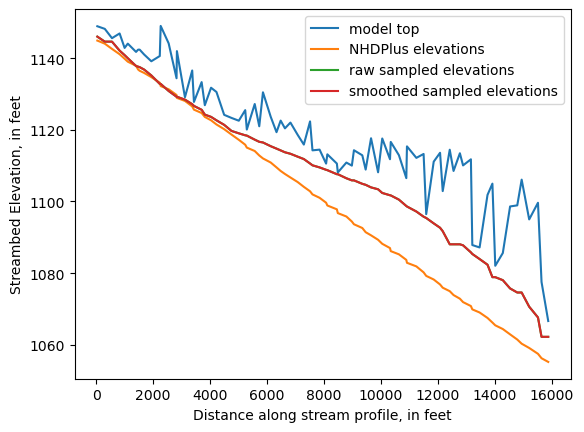

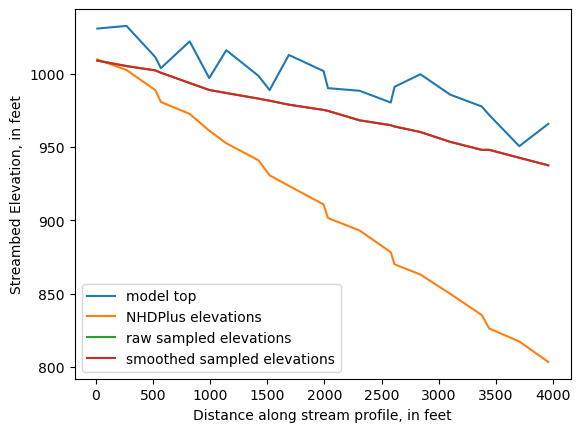

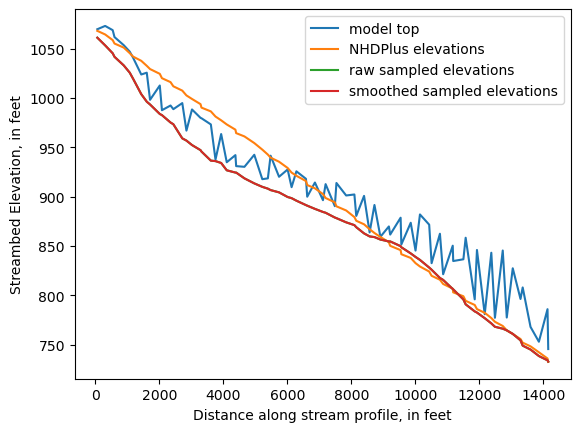

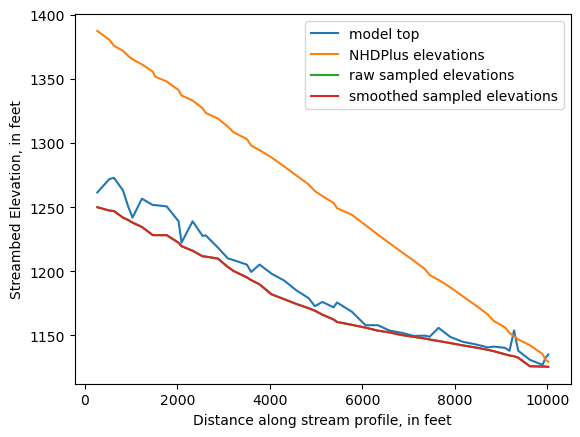

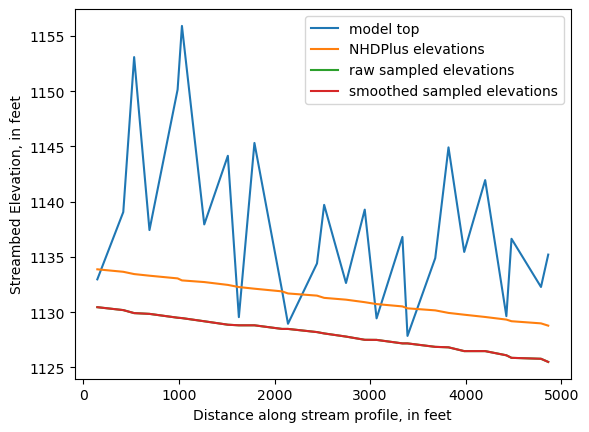

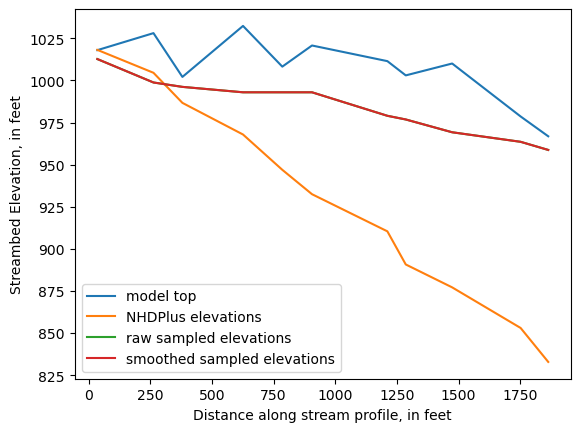

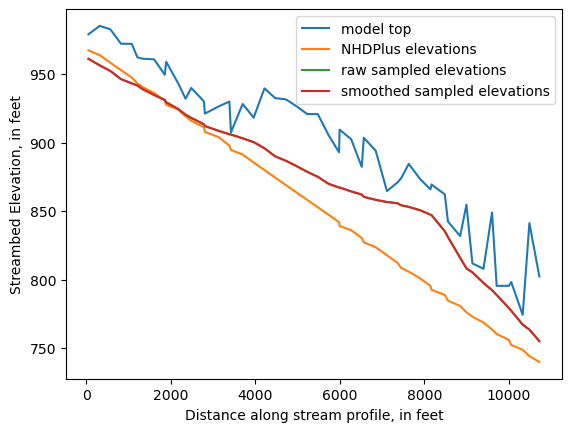

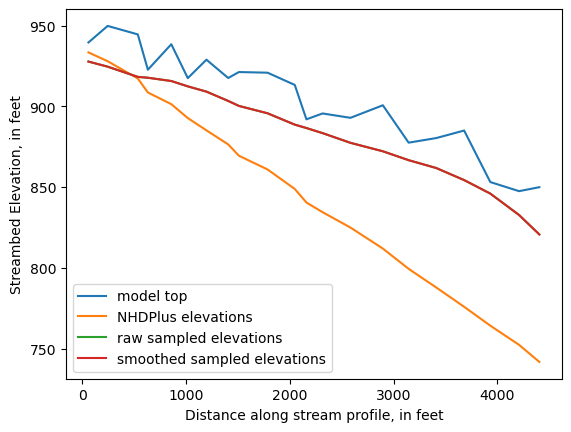

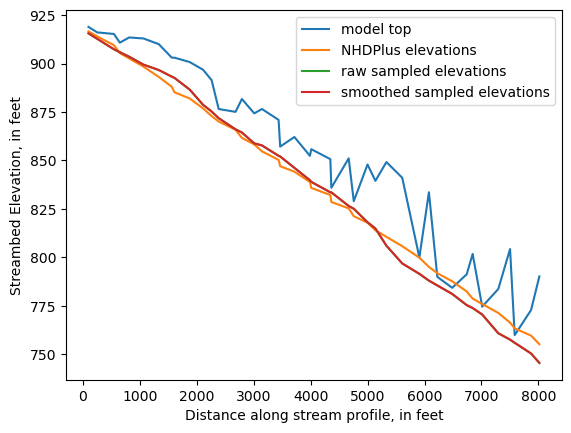

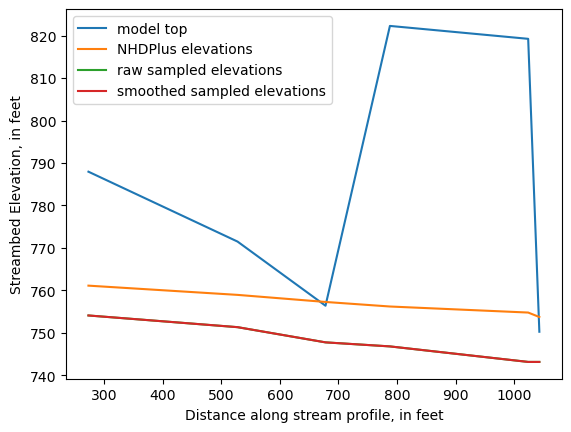

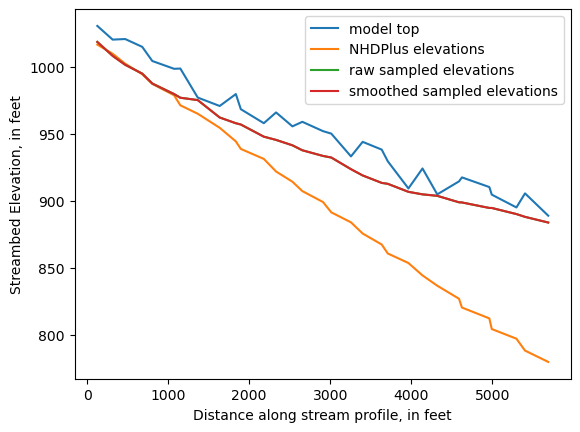

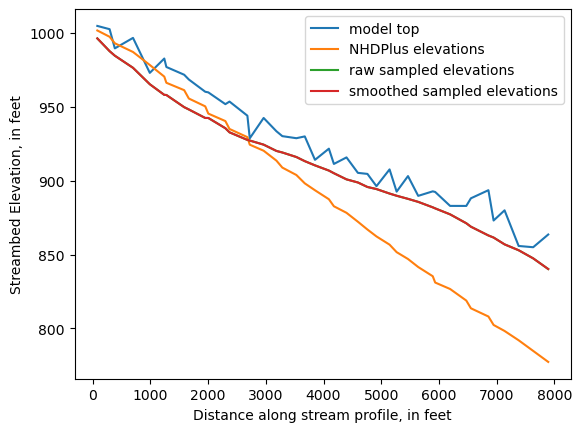

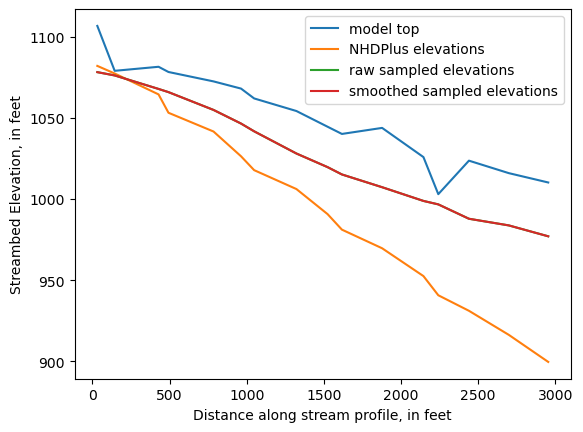

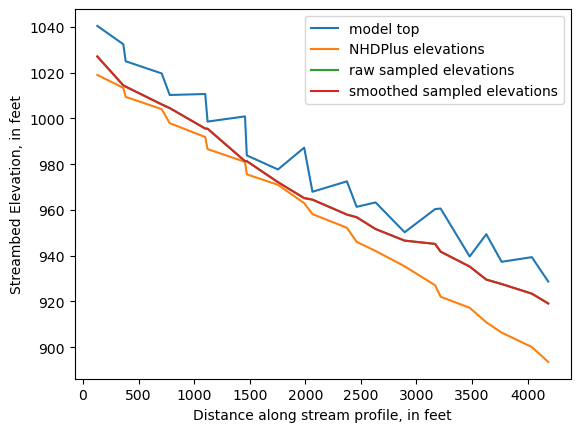

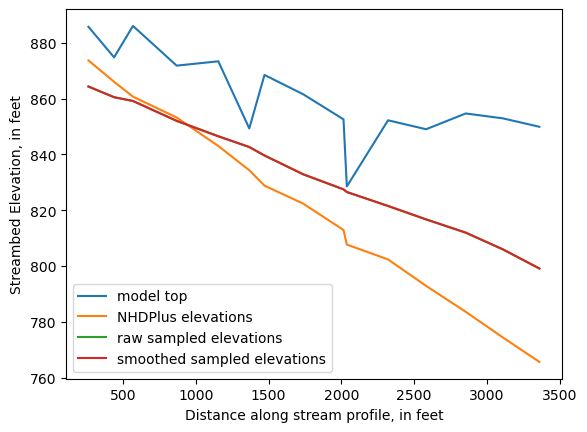

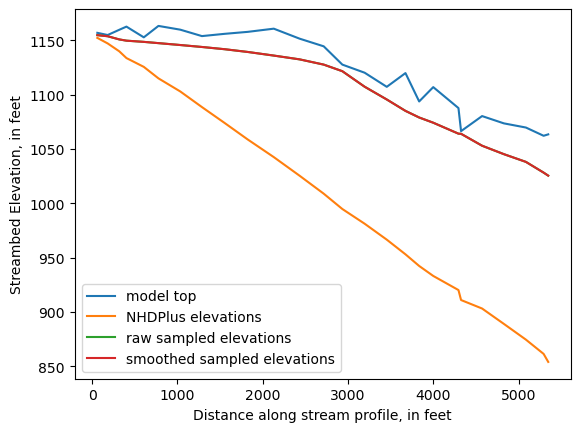

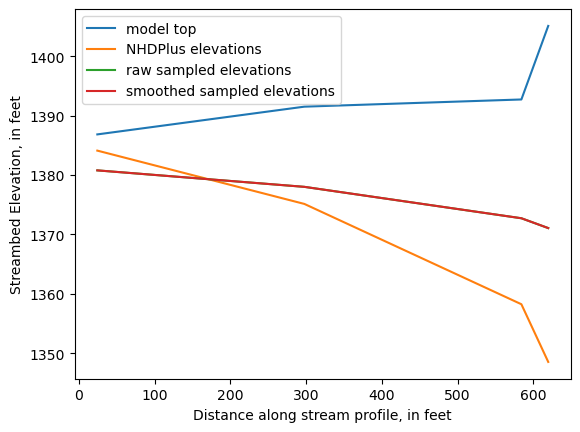

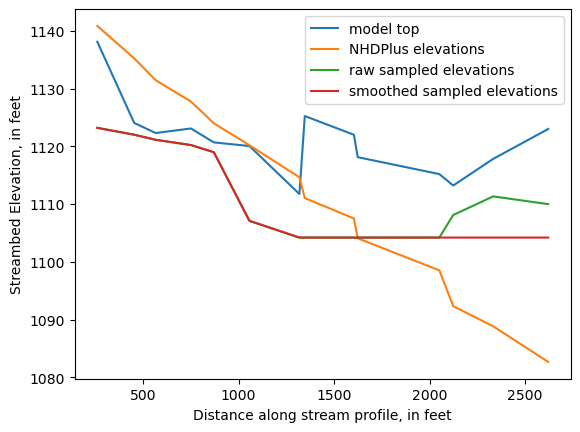

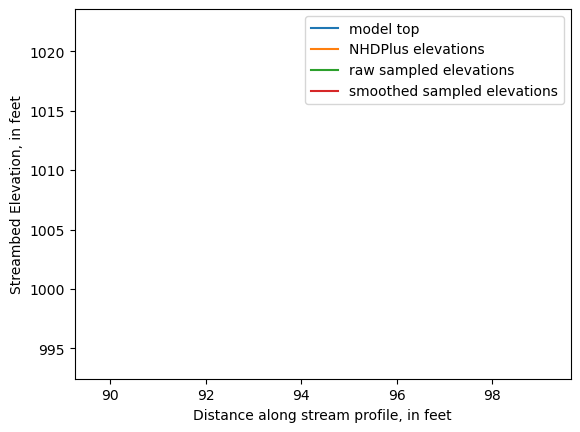

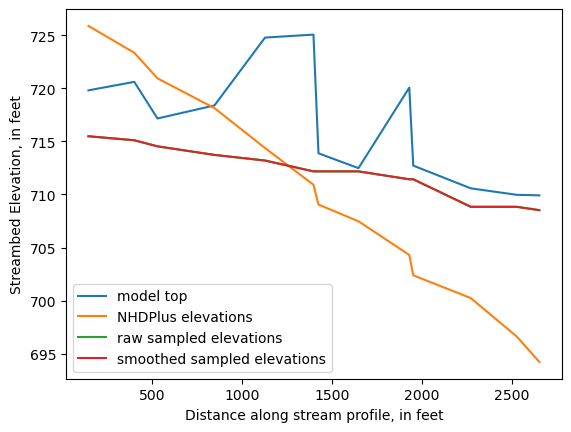

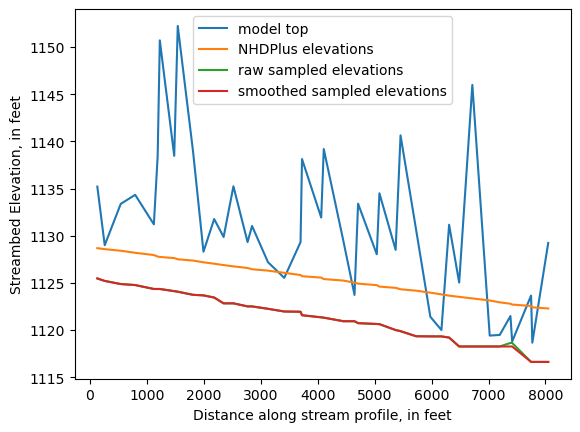

In [5]:
segments = df.groupby('iseg')
for iseg, srd in segments:
    srd = srd.copy()
    srd.index = srd.dist
    ax = srd[['model top', 'NHDPlus elevations', 'raw sampled elevations', 'smoothed sampled elevations']].plot()
    ax.set_xlabel('Distance along stream profile, in feet')
    ax.set_ylabel('Streambed Elevation, in feet')
    
    # save the profile that begins with segment 1
    if iseg == 1:
        plt.savefig('streambed_elevations_comp.pdf')